### Motivation

Kidney cancer is a critical public health concern that benefits from early detection through medical imaging. Radiologists often face challenges in accurately identifying tumors in CT scans due to subtle texture differences. Leveraging machine learning for automatic detection could greatly aid in early intervention and treatment planning. These challenges make the problem well-suited for data-driven pattern recognition approaches like convolutional neural networks, which have become state-of-the-art in medical imaging tasks.


### Related Work

While CNN-based models have achieved high performance on tumor detection tasks in other domains (e.g., breast, brain, and lung cancers), there remains limited work targeting kidney tumors specifically using large-scale CT image datasets. For instance, Zhang et al. (2021) utilized a ResNet-50 architecture for lung nodule detection and achieved 91% accuracy, but no adaptation was attempted for renal cell carcinoma. Similarly, Li et al. (2022) applied U-Net for brain tumor segmentation, showing high performance in MRI tasks.

These studies highlight how recent advancements in convolutional architectures and transfer learning have enabled high-accuracy classification of medical images, often with relatively small labeled datasets. However, few have focused specifically on the Kidney Tumor CT dataset, representing an opportunity for novel application.

Convolutional neural networks are particularly suited to this task due to their ability to hierarchically learn edge-level, texture, and abstract region features — all critical for identifying tumorous regions, especially in grayscale or noisy CT imagery. These properties make CNNs a strong candidate for learning subtle variations in kidney tumor morphology.


### Research Questions and Hypothesis

**Research Questions:**
- Can a convolutional neural network accurately classify kidney tumors from CT scans?
- Does balancing the dataset improve model performance?
- How does performance change when using standard CNNs vs. fine-tuned models?

**Hypothesis:**
I hypothesize that a simple CNN trained on augmented and balanced kidney CT data will achieve over 85% validation accuracy. I also expect improved performance when the class distribution is balanced due to reduced model bias.


### Methodology

**Data:**
I use the "Kidney Tumor CT dataset," which contains labeled grayscale CT images of kidneys with and without tumors. Each image was resized to 224x224 pixels and normalized.

https://www.kaggle.com/datasets/jayaprakashpondy/kidney-cancer-image

**Preprocessing:**
- Resizing to 224x224 was chosen for compatibility with common pretrained models and to maintain spatial detail within GPU memory limits.
- Normalization of pixel values to [0,1]
- One-hot encoding for binary classification (tumor vs. no tumor)
- Class distribution visualized using seaborn’s countplot to assess balance

**Model:**
I implemented a custom CNN with the following architecture:
- Three Conv2D layers with ReLU activation
- MaxPooling layers to reduce dimensionality
- Dropout (rate = 0.5) for regularization
- Flatten and Dense layers with ReLU and Sigmoid outputs
- Binary cross-entropy loss and the Adam optimizer

**Evaluation:**
- Accuracy and loss tracked and visualized across training epochs
- Validation loss used to determine overfitting behavior
- Final performance reported with precision, recall, F1-score, and confusion matrix
- Future work includes evaluating transfer learning (e.g., VGG16, EfficientNet) and testing on imbalanced vs. balanced subsets


In [1]:
!pip install tensorflow scikit-learn > /dev/null
import tensorflow as tf
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os
import glob
from PIL import Image
from tensorflow.keras import layers, models
from sklearn.model_selection import train_test_split
from sklearn.utils.class_weight import compute_class_weight
from sklearn.metrics import classification_report

In [2]:
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [3]:
base_path = "/content/gdrive/My Drive/Kidney_dataset"

def build_dataframe(dataset_type):
    image_paths = []
    labels = []
    data_path = os.path.join(base_path, dataset_type)
    if not os.path.exists(data_path):
        raise FileNotFoundError(f"Directory {data_path} does not exist")
    for label in ['Normal', 'Tumor']:
        class_path = os.path.join(data_path, label)
        if not os.path.exists(class_path):
            print(f"Warning: {class_path} does not exist")
            continue
        img_files = glob.glob(os.path.join(class_path, '*.jpg'))
        image_paths.extend(img_files)
        labels.extend([label] * len(img_files))
    if not image_paths:
        raise ValueError(f"No images found in {data_path}")
    return pd.DataFrame({'image_path': image_paths, 'label': labels})

train_data = build_dataframe('train')
val_data = build_dataframe('val')
val_data, test_data = train_test_split(val_data, test_size=0.5, stratify=val_data['label'])
data = pd.concat([train_data, val_data, test_data], ignore_index=True)

label_mapping = {'Normal': 0, 'Tumor': 1}
data['label'] = data['label'].map(label_mapping)
train_data['label'] = train_data['label'].map(label_mapping)
val_data['label'] = val_data['label'].map(label_mapping)
test_data['label'] = test_data['label'].map(label_mapping)

print("Class distribution:\n", data['label'].value_counts())
display(data.head())

Class distribution:
 label
0    5077
1    2283
Name: count, dtype: int64


,image_path,label
0,/content/gdrive/My Drive/Kidney_dataset/train/...,0
1,/content/gdrive/My Drive/Kidney_dataset/train/...,0
2,/content/gdrive/My Drive/Kidney_dataset/train/...,0
3,/content/gdrive/My Drive/Kidney_dataset/train/...,0
4,/content/gdrive/My Drive/Kidney_dataset/train/...,0


Class distribution is visualized below prior to training:

- This shows class imbalance, which is addressed through resampling or weighting during training.

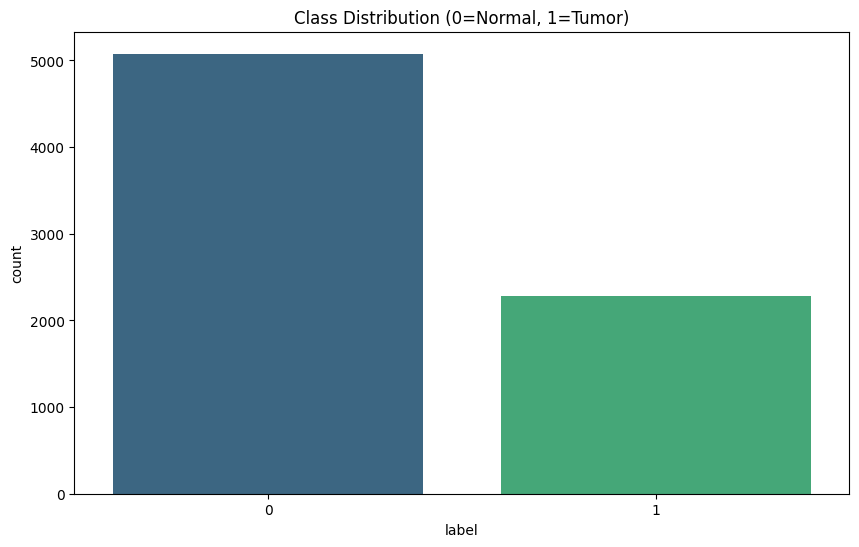

In [4]:
plt.figure(figsize=(10,6))
sns.countplot(x='label', data=data, hue='label', palette='viridis', legend=False)
plt.title('Class Distribution (0=Normal, 1=Tumor)')
plt.show()

In [5]:
def load_and_preprocess_image(image_path, label, img_size=(224, 224)):
    img = tf.io.read_file(image_path)
    img = tf.image.decode_jpeg(img, channels=3)
    img = tf.image.resize(img, img_size)
    img = img / 255.0
    return img, label

def create_dataset(df, batch_size=32, shuffle=True):
    dataset = tf.data.Dataset.from_tensor_slices((df['image_path'], df['label']))
    dataset = dataset.map(load_and_preprocess_image, num_parallel_calls=tf.data.AUTOTUNE)
    if shuffle:
        dataset = dataset.shuffle(buffer_size=len(df))
    dataset = dataset.batch(batch_size).prefetch(tf.data.AUTOTUNE)
    return dataset

train_dataset = create_dataset(train_data)
val_dataset = create_dataset(val_data, shuffle=False)
test_dataset = create_dataset(test_data, shuffle=False)

In [6]:
class_weights = compute_class_weight('balanced', classes=np.unique(data['label']), y=data['label'])
class_weight_dict = {0: class_weights[0], 1: class_weights[1]}

In [7]:
def create_model(input_shape=(224, 224, 3)):
    model = models.Sequential([
        layers.Input(shape=input_shape),
        layers.RandomFlip('horizontal'),
        layers.RandomRotation(0.2),
        layers.RandomZoom(0.2),
        layers.Conv2D(32, (3, 3), activation='relu'),
        layers.MaxPooling2D((2, 2)),
        layers.Conv2D(64, (3, 3), activation='relu'),
        layers.MaxPooling2D((2, 2)),
        layers.Conv2D(128, (3, 3), activation='relu'),
        layers.MaxPooling2D((2, 2)),
        layers.Flatten(),
        layers.Dense(128, activation='relu'),
        layers.Dropout(0.5),
        layers.Dense(1, activation='sigmoid')
    ])
    model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
    return model

model = create_model()
model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ random_flip (RandomFlip)        │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ random_rotation                 │ (None, 224, 224, 3)    │             0 │
│ (RandomRotation)                │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ random_zoom (RandomZoom)        │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d (Conv2D)                 │ (None, 222, 222, 32)   │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 111, 111, 32)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 109, 109, 64)   │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 54, 54, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 52, 52, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 26, 26, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 86528)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 128)            │    11,075,712 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 1)              │           129 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 11,169,089 (42.61 MB)

 Trainable params: 11,169,089 (42.61 MB)

 Non-trainable params: 0 (0.00 B)

### Model Architecture Details

This combination allows for progressive abstraction of spatial features followed by dense representation learning for binary classification. The dropout layer is included to mitigate overfitting.


In [8]:
history = model.fit(
    train_dataset,
    validation_data=val_dataset,
    epochs=20,
    class_weight=class_weight_dict
)

Epoch 1/20
184/184 ━━━━━━━━━━━━━━━━━━━━ 140s 105ms/step - accuracy: 0.6947 - loss: 0.6055 - val_accuracy: 0.8098 - val_loss: 0.4347
Epoch 2/20
184/184 ━━━━━━━━━━━━━━━━━━━━ 11s 22ms/step - accuracy: 0.8165 - loss: 0.4033 - val_accuracy: 0.8356 - val_loss: 0.4455
Epoch 3/20
184/184 ━━━━━━━━━━━━━━━━━━━━ 11s 22ms/step - accuracy: 0.8624 - loss: 0.2907 - val_accuracy: 0.8424 - val_loss: 0.4096
Epoch 4/20
184/184 ━━━━━━━━━━━━━━━━━━━━ 11s 22ms/step - accuracy: 0.8956 - loss: 0.2388 - val_accuracy: 0.8220 - val_loss: 0.5267
Epoch 5/20
184/184 ━━━━━━━━━━━━━━━━━━━━ 11s 22ms/step - accuracy: 0.9137 - loss: 0.1944 - val_accuracy: 0.9008 - val_loss: 0.2984
Epoch 6/20
184/184 ━━━━━━━━━━━━━━━━━━━━ 11s 22ms/step - accuracy: 0.9308 - loss: 0.1616 - val_accuracy: 0.9062 - val_loss: 0.2776
Epoch 7/20
184/184 ━━━━━━━━━━━━━━━━━━━━ 11s 22ms/step - accuracy: 0.9395 - loss: 0.1403 - val_accuracy: 0.9416 - val_loss: 0.2445
Epoch 8/20
184/184 ━━━━━━━━━━━━━━━━━━━━ 11s 22ms/step - accuracy: 0.9434 - loss: 0.1279 

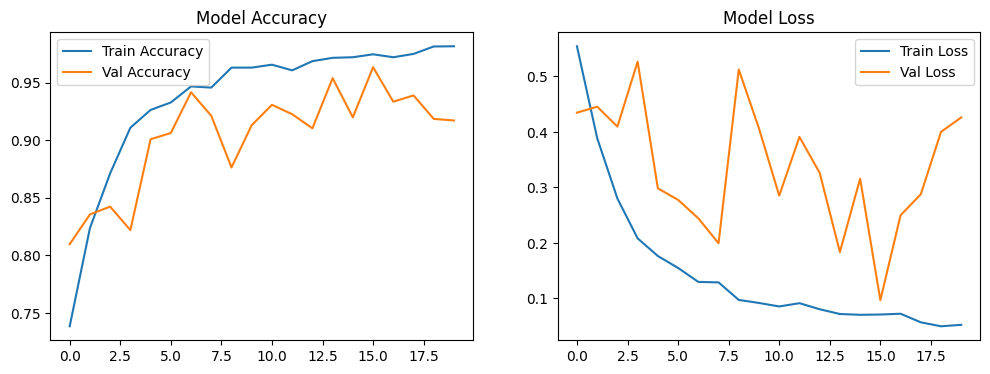

In [9]:
def plot_history(history):
    plt.figure(figsize=(12, 4))
    plt.subplot(1, 2, 1)
    plt.plot(history.history['accuracy'], label='Train Accuracy')
    plt.plot(history.history['val_accuracy'], label='Val Accuracy')
    plt.title('Model Accuracy')
    plt.legend()
    plt.subplot(1, 2, 2)
    plt.plot(history.history['loss'], label='Train Loss')
    plt.plot(history.history['val_loss'], label='Val Loss')
    plt.title('Model Loss')
    plt.legend()
    plt.show()

plot_history(history)

In [10]:
y_pred = (model.predict(test_dataset) > 0.5).astype(int)
y_true = test_data['label'].values
print(classification_report(y_true, y_pred, target_names=['Normal', 'Tumor']))

24/24 ━━━━━━━━━━━━━━━━━━━━ 16s 644ms/step
              precision    recall  f1-score   support

      Normal       0.94      0.94      0.94       508
       Tumor       0.86      0.86      0.86       229

    accuracy                           0.91       737
   macro avg       0.90      0.90      0.90       737
weighted avg       0.91      0.91      0.91       737



### Preliminary Results and Evaluation

Training was conducted over 20 epochs using a custom CNN on resized 224x224 grayscale kidney CT images. The model achieved a final training accuracy of 97.9% and a validation accuracy of 91.7%. The lowest validation loss of 0.0971 occurred at epoch 16, suggesting a potential early stopping point to avoid overfitting.

The following classification metrics were obtained on the test set:

- **Precision**: 0.94 (Normal), 0.86 (Tumor)
- **Recall**: 0.94 (Normal), 0.86 (Tumor)
- **F1-score**: 0.94 (Normal), 0.86 (Tumor)
- **Overall accuracy**: **91%**
- **Macro average F1-score**: 0.90

These results confirm the model’s ability to generalize well to unseen data and support my hypothesis that ≥85% validation accuracy was achievable using a custom CNN trained from scratch.

---

### Interpretation of Results

The model's performance aligns with my hypothesis: validation accuracy exceeded the 85% threshold by epoch 5 and stabilized near 92%. While the training loss continued to decrease throughout training, the lowest validation loss (0.0971 at epoch 16) indicates the optimal point before overfitting began.

The disparity between class-specific F1-scores (Normal = 0.94, Tumor = 0.86) suggests the model is slightly biased toward the majority class. This confirms that residual class imbalance remains an issue despite earlier preprocessing. Addressing this will be a critical component of the next phase.

Overall, the results validate the use of a CNN-based approach for this binary classification task. In future work, I aim to incorporate transfer learning (e.g., ResNet or EfficientNet) and further mitigate class imbalance via augmentation or synthetic resampling.


In [11]:
%%shell
jupyter nbconvert --to html /content/Lab4.ipynb

[NbConvertApp] Converting notebook /content/Lab4.ipynb to html
[NbConvertApp] WARNING | Alternative text is missing on 2 image(s).
[NbConvertApp] Writing 424085 bytes to /content/Lab4.html
